In [21]:
import os
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

bucket = 'ee542-sagemaker'# enter your s3 bucket where you will copy data and model artifacts
prefix = 'sagemaker/DEMO-weather' # place to upload training files within the bucket

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import time
import json
import sagemaker.amazon.common as smac

In [23]:
df = pd.read_csv('rutul_dataset.csv')

# specify columns extracted from wbdc.names
# data.columns = ["id","diagnosis","radius_mean","texture_mean","perimeter_mean","area_mean","smoothness_mean",
#                 "compactness_mean","concavity_mean","concave points_mean","symmetry_mean","fractal_dimension_mean",
#                 "radius_se","texture_se","perimeter_se","area_se","smoothness_se","compactness_se","concavity_se",
#                 "concave points_se","symmetry_se","fractal_dimension_se","radius_worst","texture_worst",
#                 "perimeter_worst","area_worst","smoothness_worst","compactness_worst","concavity_worst",
#                 "concave points_worst","symmetry_worst","fractal_dimension_worst"] 

# save the data
# data.to_csv("data.csv", sep=',', index=False)

# # print the shape of the data file
# print(data.shape)

# # show the top few rows
# display(data.head())

# # describe the data object
# display(data.describe())

# # we will also summarize the categorical field diganosis
df=df[np.isfinite(df['sm_5'])]
df=df[df.target !=0]
print(df)
display(df.describe())

#display(data.describe())


          station id  sm_5     lat      lon     soil texture    crop  low_moi  \
0               2173  0.06  34.820  -87.990             sand    corn      0.5   
1               2219  0.02  34.970 -119.480        silt loam    hops      0.8   
2               2108  0.40  33.530 -103.630             clay   wheat      0.6   
3               2064  0.27  33.630  -88.770       loamy sand    corn      0.5   
5               2144  0.69  36.570 -115.200             sand  grapes      0.6   
6                808  0.46  45.800 -111.590  fine sandy loam    hops      0.8   
7               2099  0.85  20.010 -155.600             clay    hops      0.8   
8               2003  0.22  45.470  -88.580             sand    corn      0.5   
9               2149  0.62  37.780 -118.420       silty clay  grapes      0.6   
12              2199  0.00  31.480  -96.880       silty clay  grapes      0.6   
13              2097  0.29  20.100 -155.510       loamy sand    corn      0.5   
14              2161  0.40  

,sm_5,lat,lon,low_moi,high_moi,mid_moi,target
count,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000
mean,0.265642,38.901081,-105.381261,0.631844,0.896927,0.765447,9.189246
std,0.211363,6.060871,14.250882,0.108350,0.112525,0.100544,1.533590
min,0.000000,19.910000,-162.283000,0.500000,0.750000,0.630000,3.500000
25%,0.090000,34.989250,-112.521250,0.600000,0.800000,0.700000,9.000000
50%,0.210000,38.474000,-106.364000,0.600000,1.000000,0.800000,10.000000
75%,0.420000,40.910750,-97.105000,0.800000,1.000000,0.900000,10.000000
max,0.890000,68.130000,-67.880000,0.800000,1.000000,0.900000,10.000000


In [24]:

df['soil texture'] =df['soil texture'].astype('category').cat.codes
df['weather'] =df['weather'].astype('category').cat.codes
df[df.columns[1:]].corr()['target'][:]



sm_5            0.088088
lat            -0.404950
lon             0.162645
soil texture   -0.001795
low_moi        -0.048943
high_moi       -0.038770
weather        -0.518267
mid_moi        -0.048237
target          1.000000
Name: target, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f67f0d2b2e8>,
      dtype=object)

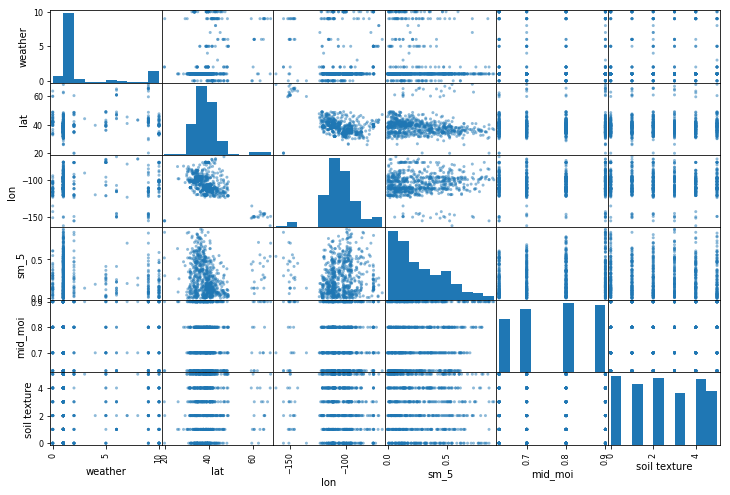

In [25]:
from pandas.plotting import scatter_matrix
attributes = ['weather','lat','lon','sm_5','mid_moi','soil texture']
scatter_matrix(df[attributes], figsize=(12, 8))

In [26]:
x = df.iloc[:,[1,9]].values
y = df.iloc[:, 10].values
print(type(x))
print(x.shape)

<class 'numpy.ndarray'>
(716, 2)


In [27]:
X=df.iloc[:,[4,5,8]]
X=pd.get_dummies(X,prefix_sep='_',drop_first=True)
X.head()
X=X.to_numpy()
print(X)
print(type(X))
print(X.shape)

[[3 1 0 0 0]
 [4 1 0 1 0]
 [0 0 0 0 1]
 ...
 [2 1 0 0 1]
 [2 1 0 1 0]
 [4 1 0 1 0]]
<class 'numpy.ndarray'>
(716, 5)


In [28]:
x=np.concatenate((x,X),axis=1)
print(type(x))

<class 'numpy.ndarray'>


In [29]:
# rand_split = np.random.rand(len(data))
# train_list = rand_split < 0.8
# val_list = (rand_split >= 0.8) & (rand_split < 0.9)
# test_list = rand_split >= 0.9

# data_train = data[train_list]
# data_val = data[val_list]
# data_test = data[test_list]

# train_y = ((data_train.iloc[:,1] == 'M') +0).as_matrix();
# train_X = data_train.iloc[:,2:].as_matrix();

# val_y = ((data_val.iloc[:,1] == 'M') +0).as_matrix();
# val_X = data_val.iloc[:,2:].as_matrix();

# test_y = ((data_test.iloc[:,1] == 'M') +0).as_matrix();
# test_X = data_test.iloc[:,2:].as_matrix();
# x = x.as_matrix()
# y = y.as_matrix()

from sklearn.model_selection import train_test_split
train_X, x_2, train_y, y_2 = train_test_split(x, y, test_size = 0.2, random_state = 0)
val_x, test_x, val_y, test_y = train_test_split(x_2, y_2, test_size = 0.5, random_state = 0)

In [30]:
train_file = 'linear_train.data'

f = io.BytesIO()
smac.write_numpy_to_dense_tensor(f, train_X.astype('float32'), train_y.astype('float32'))
f.seek(0)

boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', train_file)).upload_fileobj(f)

In [31]:
validation_file = 'linear_validation.data'

f = io.BytesIO()
smac.write_numpy_to_dense_tensor(f, val_x.astype('float32'), val_y.astype('float32'))
f.seek(0)

boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation', validation_file)).upload_fileobj(f)

In [32]:
# See 'Algorithms Provided by Amazon SageMaker: Common Parameters' in the SageMaker documentation for an explanation of these values.
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'linear-learner')

In [35]:
linear_job = 'DEMO-linear-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())



print("Job name is:", linear_job)

linear_training_params = {
    "RoleArn": role,
    "TrainingJobName": linear_job,
    "AlgorithmSpecification": {
        "TrainingImage": container,
        "TrainingInputMode": "File"
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.c4.2xlarge",
        "VolumeSizeInGB": 10
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://{}/{}/train/".format(bucket, prefix),
                    "S3DataDistributionType": "ShardedByS3Key"
                }
            },
            "CompressionType": "None",
            "RecordWrapperType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://{}/{}/validation/".format(bucket, prefix),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "CompressionType": "None",
            "RecordWrapperType": "None"
        }

    ],
    "OutputDataConfig": {
        "S3OutputPath": "s3://{}/{}/".format(bucket, prefix)
    },
    "HyperParameters": {
        "feature_dim": "7",
        "mini_batch_size": "100",
        "predictor_type": "regressor",
        "epochs": "10",
        "num_models": "32",
        "loss": "absolute_loss"
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 60 * 60
    }
}

Job name is: DEMO-linear-2019-12-02-04-41-58


In [36]:
%%time

region = boto3.Session().region_name
sm = boto3.client('sagemaker')

sm.create_training_job(**linear_training_params)

status = sm.describe_training_job(TrainingJobName=linear_job)['TrainingJobStatus']
print(status)
sm.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=linear_job)
if status == 'Failed':
    message = sm.describe_training_job(TrainingJobName=linear_job)['FailureReason']
    print('Training failed with the following error: {}'.format(message))
    raise Exception('Training job failed')

InProgress
CPU times: user 74.1 ms, sys: 0 ns, total: 74.1 ms
Wall time: 4min


---
## Host

Now that we've trained the linear algorithm on our data, let's setup a model which can later be hosted.  We will:
1. Point to the scoring container
1. Point to the model.tar.gz that came from training
1. Create the hosting model

In [37]:
linear_hosting_container = {
    'Image': container,
    'ModelDataUrl': sm.describe_training_job(TrainingJobName=linear_job)['ModelArtifacts']['S3ModelArtifacts']
}

create_model_response = sm.create_model(
    ModelName=linear_job,
    ExecutionRoleArn=role,
    PrimaryContainer=linear_hosting_container)

print(create_model_response['ModelArn'])

arn:aws:sagemaker:us-east-2:549634072032:model/demo-linear-2019-12-02-04-41-58


Once we've setup a model, we can configure what our hosting endpoints should be.  Here we specify:
1. EC2 instance type to use for hosting
1. Initial number of instances
1. Our hosting model name

In [38]:
linear_endpoint_config = 'DEMO-linear-endpoint-config-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
print(linear_endpoint_config)
create_endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName=linear_endpoint_config,
    ProductionVariants=[{
        'InstanceType': 'ml.m4.xlarge',
        'InitialInstanceCount': 1,
        'ModelName': linear_job,
        'VariantName': 'AllTraffic'}])

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

DEMO-linear-endpoint-config-2019-12-02-04-46-48
Endpoint Config Arn: arn:aws:sagemaker:us-east-2:549634072032:endpoint-config/demo-linear-endpoint-config-2019-12-02-04-46-48


Now that we've specified how our endpoint should be configured, we can create them.  This can be done in the background, but for now let's run a loop that updates us on the status of the endpoints so that we know when they are ready for use.

In [39]:
%%time

linear_endpoint = 'DEMO-linear-endpoint-' + time.strftime("%Y%m%d%H%M", time.gmtime())
print(linear_endpoint)
create_endpoint_response = sm.create_endpoint(
    EndpointName=linear_endpoint,
    EndpointConfigName=linear_endpoint_config)
print(create_endpoint_response['EndpointArn'])

resp = sm.describe_endpoint(EndpointName=linear_endpoint)
status = resp['EndpointStatus']
print("Status: " + status)

sm.get_waiter('endpoint_in_service').wait(EndpointName=linear_endpoint)

resp = sm.describe_endpoint(EndpointName=linear_endpoint)
status = resp['EndpointStatus']
print("Arn: " + resp['EndpointArn'])
print("Status: " + status)

if status != 'InService':
    raise Exception('Endpoint creation did not succeed')

DEMO-linear-endpoint-201912020446
arn:aws:sagemaker:us-east-2:549634072032:endpoint/demo-linear-endpoint-201912020446
Status: Creating
Arn: arn:aws:sagemaker:us-east-2:549634072032:endpoint/demo-linear-endpoint-201912020446
Status: InService
CPU times: user 248 ms, sys: 5.35 ms, total: 253 ms
Wall time: 8min 34s


## Predict
### Predict on Test Data

Now that we have our hosted endpoint, we can generate statistical predictions from it.  Let's predict on our test dataset to understand how accurate our model is.

There are many metrics to measure classification accuracy.  Common examples include include:
- Precision
- Recall
- F1 measure
- Area under the ROC curve - AUC
- Total Classification Accuracy 
- Mean Absolute Error

For our example, we'll keep things simple and use total classification accuracy as our metric of choice. We will also evaluate  Mean Absolute  Error (MAE) as the linear-learner has been optimized using this metric, not necessarily because it is a relevant metric from an application point of view. We'll compare the performance of the linear-learner against a naive benchmark prediction which uses majority class observed in the training data set for prediction on the test data.




### Function to convert an array to a csv

In [40]:
def np2csv(arr):
    csv = io.BytesIO()
    np.savetxt(csv, arr, delimiter=',', fmt='%g')
    return csv.getvalue().decode().rstrip()

In [45]:
runtime= boto3.client('runtime.sagemaker')

payload = np2csv(test_x)
response = runtime.invoke_endpoint(EndpointName=linear_endpoint,
                                   ContentType='text/csv',
                                   Body=payload)
result = json.loads(response['Body'].read().decode())
test_pred = np.array([r['score'] for r in result['predictions']])
print(test_pred, test_y)

[10.20377541  9.83025551  9.94254112  9.85979366  9.91891766  9.88686848
 10.03419304  9.94614887  9.99090195  9.96555901  9.93566132  9.87602711
  7.89211798  9.79621029  9.98954868  9.93466759  9.97759914  9.93566132
  9.83454037  9.97872639  9.79260254 10.07156372  9.93633747  8.78913879
  9.94254112 10.13083839  9.92078018 10.02846527  9.88213348  7.88290596
  9.99202919  9.97460938 10.31786537  9.91685581  9.93199444  9.89834976
  9.84716702  8.97255802 10.19376373 10.06547546  9.93920994 10.06367207
  9.83792114  7.71157885  9.79621029 10.00307846  9.88369274  7.76493311
  9.92226791  7.66468     9.92452145  7.89459848  8.64595509  9.96739388
  9.96874714  7.95714474  9.84716702 10.02472401  9.86948872  8.63854694
  9.89701462  7.9180479   9.93092632  9.84784317  9.97759914  9.93566132
  7.89852238 10.08103275  9.8807621   9.97940254  9.9315443  10.07199001] [ 8. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.  6. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10.  7. 10.  8. 10. 10. 10.  6. 1

Let's compare linear learner based mean absolute prediction errors from a baseline prediction which uses majority class to predict every instance.

In [48]:
from sklearn.metrics import mean_squared_error
mse=mean_squared_error(test_pred,test_y)
print(mse)

1.0254319843529283


In [ ]:
sm.delete_endpoint(EndpointName=linear_endpoint)